## Libraries

In [ ]:
!pip install kaggle

In [ ]:
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# import lightgbm as lgb
# import optuna
import optuna.integration.lightgbm as lgb_o

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it. ##
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions list

In [ ]:
!kaggle competitions download -c ventilator-pressure-prediction

In [ ]:
DEBUG = False

In [ ]:
train = pd.read_csv(r'../content/train.csv.zip')
test  = pd.read_csv(r'../content/test.csv.zip')
submission = pd.read_csv(r'../content/sample_submission.csv.zip')

In [ ]:
# train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
# test  = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
# submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')

In [ ]:
if DEBUG:
    train = train[:80*1000]

In [ ]:
train.shape, test.shape, submission.shape

In [ ]:
train

In [ ]:
train.describe()

In [ ]:
test['pressure'] = 0

In [ ]:
test

In [ ]:
test.describe()

## Add Feature

In [ ]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

In [ ]:
train = add_features(train)
test = add_features(test)

In [ ]:
train

In [ ]:
train.shape

In [ ]:
test

In [ ]:
test.shape

In [ ]:
X, y = train.drop('pressure', axis=1), train['pressure']
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
X_test, y_test = test.drop('pressure', axis=1), test['pressure']

In [ ]:
import lightgbm as lgbm

# lightGBM用のデータに変換する
trains = lgbm.Dataset(X_train, y_train, free_raw_data=False)
valids = lgbm.Dataset(X_val, y_val, free_raw_data=False)
tests  = lgbm.Dataset(X_test, y_test, free_raw_data=False)

## Light GBM && Optuna

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'mae'
}

In [ ]:
best_params = {}
model = lgb_o.train(params, trains, valid_sets = valids,
                    verbose_eval = False,
                    num_boost_round = 100,
                    early_stopping_rounds = 5,
                    #best_params = best_params,
                    #tuning_history = tuning_history,
)

In [ ]:
best_params = model.params
best_params

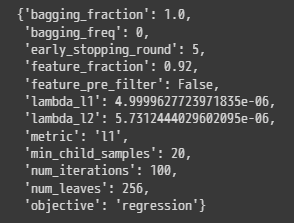

### Prediction

In [ ]:
# 調整後モデルで予測の実行
import lightgbm as lgb_original

model = lgb_original.train(best_params, trains, num_boost_round=100)
predicts = model.predict(X_test)
#best_r2 = r2_score(y_test, predicts)

In [ ]:
predicts

## Export

In [ ]:
submission['pressure'] = predicts

In [ ]:
submission.to_csv('./submission.csv', index = False)
print('./submission.csv')

In [ ]:
submission

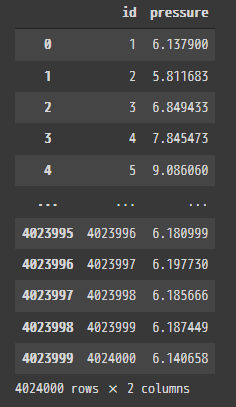

In [ ]:
!kaggle competitions submit -c ventilator-pressure-prediction -f submission.csv -m "Message"